In [5]:
import pandas as pd
import numpy as np
from ProgSnap2 import ProgSnap2Dataset
from ProgSnap2 import PS2
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import os
from os import path

In [6]:
#Snippet from "naive_model.ipynb". 
#Defining the path and semester
semester = 'F19'
BASE_PATH = os.path.join('path_to_datasets/csedm_challenge_dataset', 'F19_Release_Train_06-28-21')
TRAIN_PATH = os.path.join(BASE_PATH, 'Train')

## Preprecess Data

In [7]:
#Dataset for early Problem Performance (Aggregated from Event-Data)
early = pd.read_csv(os.path.join(TRAIN_PATH, 'early.csv'))
early["alt_Label"] = early.apply(lambda x: 1 if (x["CorrectEventually"] and x["Attempts"] <= 3) else 0, axis=1)
early

late = pd.read_csv(os.path.join(TRAIN_PATH, 'late.csv'))

### Subject Level DF

In [8]:
#Function from "naive_model.ipynb", extended by me
#Changed to use subject_id
def extract_instance_features(subject_id, early_df):
    instance = pd.DataFrame(data=[subject_id], columns=["SubjectID"])
    early_problems = early_df[early_df["SubjectID"] == subject_id]
    # Extract very naive features about the student
    # (without respect to the problem bring predicted)
    # Number of early problems attempted
    instance['ProblemsAttempted'] = early_problems.shape[0]
    # Percentage of early problems gotten correct eventually
    instance['PercCorrectEventually'] = np.mean(early_problems['CorrectEventually'])
    # Median attempts made on early problems
    instance['MedAttempts'] = np.median(early_problems['Attempts'])
    # Max attempts made on early problems
    instance['MaxAttempts'] = np.max(early_problems['Attempts'])
    # Percentage of problems gotten correct on the first try
    instance['PercCorrectFirstTry'] = np.mean(early_problems['Attempts'] == 1)
    #instance = instance.drop('SubjectID')
    instance['PercLabelledTrue'] = np.mean(early_problems["Label"] == 1)
    try:
        instance['PercAltLabelTrue'] = np.mean(early_problems["alt_Label"] == 1)
    except Exception:
        pass
    return instance


def make_subject_df(task_level_data):
    """Create a DataFrame that aggregates Task-Performance-Data on subject-level

    Args:
        task_level_data (pd.DataFrame): Task-Performance-Date aggregated from Event-Data. 
    """
    subjects = task_level_data["SubjectID"].unique()
    subject_df = pd.DataFrame(columns=["SubjectID", "ProblemsAttempted", "PercCorrectEventually", "MedAttempts", "MaxAttempts", "PercCorrectFirstTry", "PercLabelledTrue", "PercAltLabelTrue"])
    for subject in subjects:
        instance_data = extract_instance_features(subject, task_level_data)
        subject_df = subject_df.append(instance_data)
    return(subject_df)

In [9]:
subject_df = make_subject_df(early)
subject_df

,SubjectID,ProblemsAttempted,PercCorrectEventually,MedAttempts,MaxAttempts,PercCorrectFirstTry,PercLabelledTrue,PercAltLabelTrue
0,014604ba54339d4b1266cf78e125053a5ac11dd861ef3c...,30,0.966667,3.0,22,0.333333,0.833333,0.600000
0,01e96e066eff2e82627dac0493737be2de9bd2f50d6d49...,20,0.750000,4.0,15,0.300000,0.650000,0.450000
0,03000c72d4dd6a4be44ffc175dec5d9a15a83a2f8073b0...,30,0.966667,3.0,45,0.333333,0.766667,0.533333
0,0461c96c9cc0058f709704605f24136f373ba4e9ac083a...,29,0.896552,6.0,22,0.103448,0.517241,0.310345
0,048fce7bd5670d2ce6215f41856aea059973fb280ce106...,30,1.000000,3.5,26,0.333333,0.833333,0.500000
...,...,...,...,...,...,...,...,...
0,fe545219144abfb405c64d3fed4f32dc348ece7afb0a81...,30,1.000000,2.0,26,0.466667,0.900000,0.600000
0,ff02364c8aab08a51916bd6a58bf7337b5d60939ee9b53...,30,1.000000,4.0,38,0.266667,0.633333,0.433333
0,ff4cfd98fc176f36fa99b2bc839990d2fd13de4e59b5c4...,30,0.933333,3.5,34,0.233333,0.800000,0.500000
0,ff86d28801139f82f29ac25c715647674d50977478b8d8...,30,1.000000,3.0,31,0.266667,0.866667,0.633333


### Generate Response matrices

In [10]:
#Obtain Matrix of Response-vectors
U = pd.crosstab(index = early["SubjectID"], 
            columns=[early["AssignmentID"], early["ProblemID"]], 
            values=early["Label"],
            aggfunc="sum")
#At the moment we will delete missing values row-wise. It will be usefull to impute values later, since missing at random is unlikely
U = U.dropna()
U


AssignmentID                                        439                      \
ProblemID                                           1    3    5    12   13    
SubjectID                                                                     
014604ba54339d4b1266cf78e125053a5ac11dd861ef3cc...  1.0  1.0  1.0  1.0  1.0   
03000c72d4dd6a4be44ffc175dec5d9a15a83a2f8073b08...  1.0  0.0  1.0  1.0  1.0   
048fce7bd5670d2ce6215f41856aea059973fb280ce1067...  0.0  0.0  1.0  1.0  1.0   
04ed28ab2b2a010c686bf190a5f001dfdc7d9ec41859048...  1.0  1.0  1.0  1.0  1.0   
072db31ce670255297c5d67fd00068faf81a7f50223b5a5...  1.0  1.0  1.0  1.0  1.0   
...                                                 ...  ...  ...  ...  ...   
fe545219144abfb405c64d3fed4f32dc348ece7afb0a814...  1.0  1.0  1.0  0.0  1.0   
ff02364c8aab08a51916bd6a58bf7337b5d60939ee9b538...  0.0  0.0  1.0  0.0  1.0   
ff4cfd98fc176f36fa99b2bc839990d2fd13de4e59b5c4a...  1.0  1.0  1.0  1.0  0.0   
ff86d28801139f82f29ac25c715647674d50977478b8d84...  1.0  1.0  1.0  1.0  1.0   
ffc3b91c3744d275e99f49e105f016732d694a76314d8cd...  1.0  1.0  1.0  1.0  1.0   

AssignmentID                                                                 \
ProblemID                                           232  233  234  235  236   
SubjectID                                                                     
014604ba54339d4b1266cf78e125053a5ac11dd861ef3cc...  1.0  1.0  1.0  1.0  1.0   
03000c72d4dd6a4be44ffc175dec5d9a15a83a2f8073b08...  1.0  1.0  0.0  1.0  1.0   
048fce7bd5670d2ce6215f41856aea059973fb280ce1067...  1.0  1.0  0.0  1.0  1.0   
04ed28ab2b2a010c686bf190a5f001dfdc7d9ec41859048...  1.0  0.0  1.0  1.0  1.0   
072db31ce670255297c5d67fd00068faf81a7f50223b5a5...  1.0  1.0  1.0  1.0  1.0   
...                                                 ...  ...  ...  ...  ...   
fe545219144abfb405c64d3fed4f32dc348ece7afb0a814...  1.0  1.0  1.0  1.0  1.0   
ff02364c8aab08a51916bd6a58bf7337b5d60939ee9b538...  1.0  1.0  0.0  1.0  1.0   
ff4cfd98fc176f36fa99b2bc839990d2fd13de4e59b5c4a...  0.0  1.0  1.0  0.0  1.0   
ff86d28801139f82f29ac25c715647674d50977478b8d84...  1.0  1.0  0.0  0.0  1.0   
ffc3b91c3744d275e99f49e105f016732d694a76314d8cd...  1.0  1.0  1.0  1.0  1.0   

AssignmentID                                        ...  492                 \
ProblemID                                           ...  31   32   33   34    
SubjectID                                           ...                       
014604ba54339d4b1266cf78e125053a5ac11dd861ef3cc...  ...  1.0  0.0  0.0  0.0   
03000c72d4dd6a4be44ffc175dec5d9a15a83a2f8073b08...  ...  0.0  0.0  0.0  1.0   
048fce7bd5670d2ce6215f41856aea059973fb280ce1067...  ...  1.0  1.0  1.0  1.0   
04ed28ab2b2a010c686bf190a5f001dfdc7d9ec41859048...  ...  1.0  1.0  1.0  1.0   
072db31ce670255297c5d67fd00068faf81a7f50223b5a5...  ...  1.0  1.0  1.0  1.0   
...                                                 ...  ...  ...  ...  ...   
fe545219144abfb405c64d3fed4f32dc348ece7afb0a814...  ...  1.0  1.0  1.0  1.0   
ff02364c8aab08a51916bd6a58bf7337b5d60939ee9b538...  ...  1.0  0.0  1.0  0.0   
ff4cfd98fc176f36fa99b2bc839990d2fd13de4e59b5c4a...  ...  1.0  1.0  1.0  1.0   
ff86d28801139f82f29ac25c715647674d50977478b8d84...  ...  1.0  0.0  1.0  1.0   
ffc3b91c3744d275e99f49e105f016732d694a76314d8cd...  ...  1.0  1.0  1.0  1.0   

AssignmentID                                                                 \
ProblemID                                           36   37   38   39   40    
SubjectID                                                                     
014604ba54339d4b1266cf78e125053a5ac11dd861ef3cc...  1.0  1.0  0.0  1.0  1.0   
03000c72d4dd6a4be44ffc175dec5d9a15a83a2f8073b08...  1.0  1.0  0.0  1.0  1.0   
048fce7bd5670d2ce6215f41856aea059973fb280ce1067...  1.0  1.0  1.0  1.0  1.0   
04ed28ab2b2a010c686bf190a5f001dfdc7d9ec41859048...  1.0  1.0  1.0  1.0  1.0   
072db31ce670255297c5d67fd00068faf81a7f50223b5a5...  1.0  1.0  1.0  1.0  1.0   
...                                            

In [11]:
#Obtain Matrix of Response-vectors
alt_U = pd.crosstab(index = early["SubjectID"], 
            columns=[early["AssignmentID"], early["ProblemID"]], 
            values=early["alt_Label"],
            aggfunc="sum")
#At the moment we will delete missing values row-wise. It will be usefull to impute values later, since missing at random is unlikely
alt_U = alt_U.dropna()
alt_U

AssignmentID                                        439                      \
ProblemID                                           1    3    5    12   13    
SubjectID                                                                     
014604ba54339d4b1266cf78e125053a5ac11dd861ef3cc...  1.0  1.0  1.0  1.0  1.0   
03000c72d4dd6a4be44ffc175dec5d9a15a83a2f8073b08...  1.0  0.0  1.0  1.0  1.0   
048fce7bd5670d2ce6215f41856aea059973fb280ce1067...  0.0  0.0  1.0  1.0  1.0   
04ed28ab2b2a010c686bf190a5f001dfdc7d9ec41859048...  1.0  1.0  1.0  1.0  0.0   
072db31ce670255297c5d67fd00068faf81a7f50223b5a5...  1.0  1.0  1.0  1.0  1.0   
...                                                 ...  ...  ...  ...  ...   
fe545219144abfb405c64d3fed4f32dc348ece7afb0a814...  1.0  1.0  0.0  0.0  0.0   
ff02364c8aab08a51916bd6a58bf7337b5d60939ee9b538...  0.0  0.0  1.0  1.0  1.0   
ff4cfd98fc176f36fa99b2bc839990d2fd13de4e59b5c4a...  1.0  0.0  1.0  1.0  0.0   
ff86d28801139f82f29ac25c715647674d50977478b8d84...  1.0  1.0  1.0  1.0  1.0   
ffc3b91c3744d275e99f49e105f016732d694a76314d8cd...  1.0  1.0  1.0  1.0  1.0   

AssignmentID                                                                 \
ProblemID                                           232  233  234  235  236   
SubjectID                                                                     
014604ba54339d4b1266cf78e125053a5ac11dd861ef3cc...  1.0  1.0  1.0  0.0  1.0   
03000c72d4dd6a4be44ffc175dec5d9a15a83a2f8073b08...  0.0  0.0  0.0  1.0  1.0   
048fce7bd5670d2ce6215f41856aea059973fb280ce1067...  1.0  1.0  0.0  1.0  0.0   
04ed28ab2b2a010c686bf190a5f001dfdc7d9ec41859048...  1.0  0.0  1.0  1.0  1.0   
072db31ce670255297c5d67fd00068faf81a7f50223b5a5...  1.0  1.0  1.0  1.0  1.0   
...                                                 ...  ...  ...  ...  ...   
fe545219144abfb405c64d3fed4f32dc348ece7afb0a814...  0.0  0.0  0.0  0.0  0.0   
ff02364c8aab08a51916bd6a58bf7337b5d60939ee9b538...  1.0  1.0  0.0  1.0  1.0   
ff4cfd98fc176f36fa99b2bc839990d2fd13de4e59b5c4a...  0.0  1.0  1.0  0.0  1.0   
ff86d28801139f82f29ac25c715647674d50977478b8d84...  0.0  1.0  0.0  0.0  1.0   
ffc3b91c3744d275e99f49e105f016732d694a76314d8cd...  1.0  1.0  1.0  1.0  1.0   

AssignmentID                                        ...  492                 \
ProblemID                                           ...  31   32   33   34    
SubjectID                                           ...                       
014604ba54339d4b1266cf78e125053a5ac11dd861ef3cc...  ...  1.0  0.0  0.0  0.0   
03000c72d4dd6a4be44ffc175dec5d9a15a83a2f8073b08...  ...  0.0  0.0  0.0  1.0   
048fce7bd5670d2ce6215f41856aea059973fb280ce1067...  ...  0.0  0.0  1.0  1.0   
04ed28ab2b2a010c686bf190a5f001dfdc7d9ec41859048...  ...  1.0  1.0  1.0  0.0   
072db31ce670255297c5d67fd00068faf81a7f50223b5a5...  ...  1.0  1.0  1.0  1.0   
...                                                 ...  ...  ...  ...  ...   
fe545219144abfb405c64d3fed4f32dc348ece7afb0a814...  ...  1.0  1.0  1.0  1.0   
ff02364c8aab08a51916bd6a58bf7337b5d60939ee9b538...  ...  0.0  0.0  0.0  0.0   
ff4cfd98fc176f36fa99b2bc839990d2fd13de4e59b5c4a...  ...  1.0  0.0  0.0  0.0   
ff86d28801139f82f29ac25c715647674d50977478b8d84...  ...  1.0  0.0  0.0  1.0   
ffc3b91c3744d275e99f49e105f016732d694a76314d8cd...  ...  1.0  1.0  1.0  1.0   

AssignmentID                                                                 \
ProblemID                                           36   37   38   39   40    
SubjectID                                                                     
014604ba54339d4b1266cf78e125053a5ac11dd861ef3cc...  1.0  1.0  0.0  1.0  0.0   
03000c72d4dd6a4be44ffc175dec5d9a15a83a2f8073b08...  0.0  1.0  0.0  0.0  0.0   
048fce7bd5670d2ce6215f41856aea059973fb280ce1067...  1.0  1.0  0.0  1.0  0.0   
04ed28ab2b2a010c686bf190a5f001dfdc7d9ec41859048...  0.0  0.0  1.0  0.0  1.0   
072db31ce670255297c5d67fd00068faf81a7f50223b5a5...  1.0  1.0  1.0  1.0  1.0   
...                                            

In [12]:
from knowledge_growth_model_uirt_lfa import ICC

#Plot all ICC's according to their current parameters
def plot_iccs(a, b, range=[-5,5], step=0.2, title=""):
    for i, discrimination in enumerate(a):
        x = np.arange(start=range[0], stop=range[1], step=step)
        y = ICC([a[i], b[i]], x)
        plt.plot(x,y)
        plt.title(title)

In [13]:
#Obtain Matrix of Response-vectors
late_U = pd.crosstab(index = late["SubjectID"], 
            columns=[late["AssignmentID"], late["ProblemID"]], 
            values=late["Label"],
            aggfunc="sum")
#At the moment we will delete missing values row-wise. It will be usefull to impute values later, since missing at random is unlikely
late_U = late_U.dropna()
late_U

AssignmentID                                        494                      \
ProblemID                                           41   43   44   46   49    
SubjectID                                                                     
014604ba54339d4b1266cf78e125053a5ac11dd861ef3cc...  1.0  1.0  1.0  1.0  1.0   
03000c72d4dd6a4be44ffc175dec5d9a15a83a2f8073b08...  0.0  0.0  1.0  0.0  0.0   
0461c96c9cc0058f709704605f24136f373ba4e9ac083a1...  1.0  1.0  1.0  0.0  0.0   
048fce7bd5670d2ce6215f41856aea059973fb280ce1067...  1.0  1.0  1.0  1.0  1.0   
04ed28ab2b2a010c686bf190a5f001dfdc7d9ec41859048...  0.0  1.0  1.0  1.0  1.0   
...                                                 ...  ...  ...  ...  ...   
fe545219144abfb405c64d3fed4f32dc348ece7afb0a814...  1.0  1.0  1.0  1.0  1.0   
ff02364c8aab08a51916bd6a58bf7337b5d60939ee9b538...  0.0  1.0  1.0  0.0  1.0   
ff4cfd98fc176f36fa99b2bc839990d2fd13de4e59b5c4a...  1.0  1.0  1.0  1.0  1.0   
ff86d28801139f82f29ac25c715647674d50977478b8d84...  1.0  1.0  1.0  1.0  1.0   
ffc3b91c3744d275e99f49e105f016732d694a76314d8cd...  1.0  1.0  1.0  1.0  1.0   

AssignmentID                                                                 \
ProblemID                                           67   104  106  107  108   
SubjectID                                                                     
014604ba54339d4b1266cf78e125053a5ac11dd861ef3cc...  1.0  1.0  0.0  1.0  0.0   
03000c72d4dd6a4be44ffc175dec5d9a15a83a2f8073b08...  0.0  1.0  1.0  0.0  1.0   
0461c96c9cc0058f709704605f24136f373ba4e9ac083a1...  0.0  0.0  1.0  0.0  0.0   
048fce7bd5670d2ce6215f41856aea059973fb280ce1067...  1.0  1.0  1.0  1.0  1.0   
04ed28ab2b2a010c686bf190a5f001dfdc7d9ec41859048...  1.0  1.0  1.0  1.0  1.0   
...                                                 ...  ...  ...  ...  ...   
fe545219144abfb405c64d3fed4f32dc348ece7afb0a814...  1.0  1.0  1.0  1.0  1.0   
ff02364c8aab08a51916bd6a58bf7337b5d60939ee9b538...  1.0  0.0  0.0  0.0  1.0   
ff4cfd98fc176f36fa99b2bc839990d2fd13de4e59b5c4a...  1.0  1.0  1.0  1.0  1.0   
ff86d28801139f82f29ac25c715647674d50977478b8d84...  1.0  1.0  1.0  1.0  1.0   
ffc3b91c3744d275e99f49e105f016732d694a76314d8cd...  1.0  0.0  0.0  1.0  0.0   

AssignmentID                                        502                      \
ProblemID                                           45   48   51   56   57    
SubjectID                                                                     
014604ba54339d4b1266cf78e125053a5ac11dd861ef3cc...  1.0  1.0  0.0  1.0  1.0   
03000c72d4dd6a4be44ffc175dec5d9a15a83a2f8073b08...  0.0  0.0  0.0  1.0  0.0   
0461c96c9cc0058f709704605f24136f373ba4e9ac083a1...  0.0  0.0  0.0  1.0  1.0   
048fce7bd5670d2ce6215f41856aea059973fb280ce1067...  1.0  1.0  1.0  1.0  1.0   
04ed28ab2b2a010c686bf190a5f001dfdc7d9ec41859048...  1.0  1.0  1.0  1.0  1.0   
...                                                 ...  ...  ...  ...  ...   
fe545219144abfb405c64d3fed4f32dc348ece7afb0a814...  1.0  1.0  1.0  1.0  1.0   
ff02364c8aab08a51916bd6a58bf7337b5d60939ee9b538...  0.0  0.0  1.0  1.0  1.0   
ff4cfd98fc176f36fa99b2bc839990d2fd13de4e59b5c4a...  1.0  1.0  1.0  1.0  1.0   
ff86d28801139f82f29ac25c715647674d50977478b8d84...  1.0  1.0  1.0  1.0  1.0   
ffc3b91c3744d275e99f49e105f016732d694a76314d8cd...  1.0  1.0  0.0  1.0  1.0   

AssignmentID                                                                 
ProblemID                                           64   70   71   112  118  
SubjectID                                                                    
014604ba54339d4b1266cf78e125053a5ac11dd861ef3cc...  0.0  0.0  1.0  1.0  1.0  
03000c72d4dd6a4be44ffc175dec5d9a15a83a2f8073b08...  1.0  0.0  1.0  1.0  1.0  
0461c96c9cc0058f709704605f24136f373ba4e9ac083a1...  0.0  0.0  0.0  0.0  1.0  
048fce7bd5670d2ce6215f41856aea059973fb280ce1067...  1.0  1.0  1.0  1.0  1.0  
04ed28ab2b2a010c686bf190a5f001dfdc7d9ec41859048...  1.0  1.0  1.0  1.0  1.0  
...                                                 ...

### Test Data

In [15]:
TEST_PATH = os.path.join("path_to_datasets/csedm_challenge_dataset/F19_Release_Test_06-28-21/test")

test_ps2 = ProgSnap2Dataset(os.path.join(TEST_PATH, 'Data'))
early_test = pd.read_csv(os.path.join(TEST_PATH, 'early.csv'))
late_test = pd.read_csv(os.path.join(TEST_PATH, 'late.csv'))

test_subject_df = make_subject_df(early_test)
test_subject_df = test_subject_df.drop("PercAltLabelTrue", 1)

#Obtain Matrix of Response-vectors
test_U = pd.crosstab(index = early_test["SubjectID"], 
            columns=[early_test["AssignmentID"], early_test["ProblemID"]], 
            values=early_test["Label"],
            aggfunc="sum")
#At the moment we will delete missing values row-wise. It will be usefull to impute values later, since missing at random is unlikely
#test_U = test_U.fillna(test_U.median())
miss_indices_early = np.where(np.isnan(test_U.to_numpy().flatten()))

#Obtain Matrix of Response-vectors
test_late_U = pd.crosstab(index = late_test["SubjectID"], 
            columns=[late_test["AssignmentID"], late_test["ProblemID"]], 
            values=early_test["Label"],
            aggfunc="sum")
#At the moment we will delete missing values row-wise. It will be usefull to impute values later, since missing at random is unlikely
#test_U = test_U.fillna(test_U.median())
miss_indices_late = np.where(np.isnan(test_late_U.to_numpy().flatten()))
miss_indices_late

(array([ 365,  366,  367,  368,  369,  400,  401,  402,  403,  404,  405,
         406,  407,  408,  409,  559,  770,  771,  772,  773,  774,  775,
         776,  777,  778,  779,  915, 1038, 1277, 1279, 1460, 1461, 1462,
        1463, 1464, 1465, 1466, 1467, 1468, 1469, 1474, 1475, 1476, 1478,
        1479, 1787, 1788, 1799, 1955, 1959, 1989, 1990, 1991, 1992, 1993,
        1994, 1995, 1996, 1997, 1998, 1999, 2072, 2074, 2075, 2076, 2077,
        2078, 2079, 2110, 2111, 2112, 2113, 2114, 2115, 2116, 2117, 2118,
        2119, 2305, 2306, 2307, 2308, 2317, 2318, 2319, 2350, 2351, 2352,
        2353, 2354, 2355, 2356, 2357, 2358, 2359], dtype=int64),)

## Use new Model Module for standard MMLE EM-Algorithm

In [16]:
from importlib import reload
import knowledge_growth_model_uirt_lfa 
reload(knowledge_growth_model_uirt_lfa)

model = knowledge_growth_model_uirt_lfa.knowledge_growth_model()
model.fit(early_response_data=U, late_response_data=late_U)

Fit early Item Parameters:
Step: 1: current parameter_diff: [10.33900802761106, 34.23682360426246], current data likelihood: 29534.56407172259
Step: 2: current parameter_diff: [6.604788269675666, 18.90925325251881], current data likelihood: 28739.952267346347
Step: 3: current parameter_diff: [3.257575854567439, 12.681500431434426], current data likelihood: 28296.652459079018
Step: 4: current parameter_diff: [1.898329075907111, 16.51207497234919], current data likelihood: 27869.73987173368
Step: 5: current parameter_diff: [1.3124360368118568, 16.360505258936755], current data likelihood: 27623.271412523805
Step: 6: current parameter_diff: [1.0115847794984139, 13.615734679974313], current data likelihood: 27486.44500371764
Step: 7: current parameter_diff: [0.6842466969489829, 11.946199225499218], current data likelihood: 27415.14671025452
Step: 8: current parameter_diff: [0.7384065081723589, 20.38163756541238], current data likelihood: 27378.098833116983
Step: 9: current parameter_diff: 

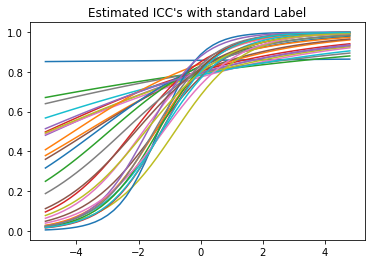

In [17]:
#ICC's for EM-Result with standard Label
a_hat= model.a_hat
b_hat = model.b_hat

plot_iccs(a_hat, b_hat, range=[-5, 5], title="Estimated ICC's with standard Label")

### Predict Answers

#### Train

In [18]:
pred_train = np.squeeze(model.predict_answers(U))
p_train = model.predict_answers(U, return_p=True)

In [19]:
model.get_training_performance(U, late_U)

Accuracy per Question: 
[0.79642857 0.79285714 0.82857143 0.75357143 0.74642857 0.74642857
 0.74642857 0.74285714 0.78928571 0.68928571 0.76071429 0.81071429
 0.72857143 0.75357143 0.8        0.75357143 0.71071429 0.725
 0.79285714 0.78214286] 
Overall acuracy: 0.7625
AUC-Score: 0.7529561432947016


## Add more Features

In [20]:
#Setting up a ProgSnap2 Dataset (this is the data format used in the Challenge.)
train_ps2 = ProgSnap2Dataset(os.path.join(TRAIN_PATH, 'Data')) 

In [21]:
#Extracted from code_feature_model.ipynb
def get_code_table(ps2_dataset):
    events_table = ps2_dataset.get_main_table()
    code_states = ps2_dataset.get_code_states_table()
    runs = events_table.merge(code_states, on=PS2.CodeStateID)
    runs = runs[runs[PS2.EventType] == 'Run.Program']
    runs = runs[[PS2.Order, PS2.SubjectID, PS2.ProblemID, 'Code']]
    return runs

In [22]:
code_table_train = get_code_table(train_ps2)

# Some empty strings got imported as "NaN", so we turn them back
code_table_train['Code'][code_table_train['Code'].apply(lambda x: not isinstance(x, str))] = ""
code_table_train

,Order,SubjectID,ProblemID,Code
0,179362,014604ba54339d4b1266cf78e125053a5ac11dd861ef3c...,1,"public int sortaSum(int a, int b)\r\n{\r\n ..."
2,179364,014604ba54339d4b1266cf78e125053a5ac11dd861ef3c...,3,"public boolean in1To10(int n, boolean outsideM..."
4,179358,014604ba54339d4b1266cf78e125053a5ac11dd861ef3c...,5,"public boolean answerCell(boolean isMorning, b..."
6,179366,014604ba54339d4b1266cf78e125053a5ac11dd861ef3c...,12,"public boolean squirrelPlay(int temp, boolean ..."
8,179331,014604ba54339d4b1266cf78e125053a5ac11dd861ef3c...,13,"public int caughtSpeeding(int speed, boolean i..."
...,...,...,...,...
262387,458819,ffc3b91c3744d275e99f49e105f016732d694a76314d8c...,71,public boolean canBalance(int[] nums)\r\n{\r\n...
262389,458821,ffc3b91c3744d275e99f49e105f016732d694a76314d8c...,112,public int[] seriesUp(int n)\r\n{\r\n int[]...
262392,458824,ffc3b91c3744d275e99f49e105f016732d694a76314d8c...,112,public int[] seriesUp(int n)\r\n{\r\n int[]...
262394,458826,ffc3b91c3744d275e99f49e105f016732d694a76314d8c...,118,public int[] shiftLeft(int[] nums)\r\n{\r\n ...


In [23]:
code_table_test = get_code_table(test_ps2)

# Some empty strings got imported as "NaN", so we turn them bcak
code_table_test['Code'][code_table_test['Code'].apply(lambda x: not isinstance(x, str))] = ""

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Note this approach is _very_ naive, since it's using NLP assumptions
# about tokenizing, among other things, but it is good enough for a demonstration.
code_vectorizer = TfidfVectorizer(max_features=100)
code_vectorizer.fit(code_table_train['Code'])
top_vocab = code_vectorizer.vocabulary_
top_vocab

def create_encoder_dict(code_df):
    code_problem_encoders = {}
    problem_ids = code_df["ProblemID"].unique()
    for problem_id in problem_ids:
        code = code_df['Code'][code_df["ProblemID"] == problem_id]
        #problem_id = rows[PS2.ProblemID].iloc[0]
        code_vectorizer = TfidfVectorizer(vocabulary=top_vocab)
        code_vectorizer.fit(code)
        code_problem_encoders[problem_id] = code_vectorizer
    return(code_problem_encoders)
        
encoder_dict = create_encoder_dict(code_df=code_table_train)


In [25]:
def create_embeddings(code_df, encoder_dict):
    problem_ids = code_df["ProblemID"].unique()
    #Create Embedding_Dataset
    for i, problem_id in enumerate(problem_ids):
        vectorizer = encoder_dict[problem_id]
        code_part = code_df[["SubjectID", "Code"]][code_df["ProblemID"] == problem_id]
        embedding = vectorizer.transform(code_part["Code"]).todense()
        index = pd.MultiIndex.from_arrays([code_part["SubjectID"], pd.Series([problem_id for i in code_part.index])], names=('SubjectID', 'ProblemID'))
        if i == 0:
            embedding_df = pd.DataFrame(embedding, index=index)
        else:
            embedding_df = pd.concat((embedding_df, pd.DataFrame(embedding, index=index)), axis=0)
    #Reshape Embeddings Dataset
    #Generate a complete Index for all Problems and Subjects
    all_problems = pd.DataFrame(code_df.ProblemID.unique(), columns=["ProblemID"])
    all_problems["key"] = 1
    all_subjects = pd.DataFrame(code_df.SubjectID.unique(), columns=["SubjectID"])
    all_subjects["key"] = 1
    complete_index = pd.merge(all_subjects,all_problems,on="key").drop("key", 1)
    complete_index.columns = ["SubjectID", "ProblemID"]
    
    #Average over Problems that were attempted multiple times by the same subject
    mean_problem_idf = pd.DataFrame(embedding_df).groupby(embedding_df.index).mean()
    mean_problem_idf = mean_problem_idf.reindex(complete_index).to_numpy().reshape(len(all_subjects),100*len(all_problems))
    mean_problem_idf = pd.DataFrame(mean_problem_idf, index = all_subjects["SubjectID"])
    mean_problem_idf

    return(mean_problem_idf)

In [26]:
code_embeddings = create_embeddings(code_table_train, encoder_dict)
test_code_embeddings = create_embeddings(code_table_test, encoder_dict)
code_embeddings

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
SubjectID,,,,,,,,,,,,,,,,,,,,,
014604ba54339d4b1266cf78e125053a5ac11dd861ef3cc0b4ed777ed0e2af0a,0.0,0.100614,0.0,0.0,0.105679,0.097386,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01e96e066eff2e82627dac0493737be2de9bd2f50d6d498bb6420906c7164c05,0.0,0.206504,0.0,0.0,0.216898,0.199877,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
03000c72d4dd6a4be44ffc175dec5d9a15a83a2f8073b08b27be1fb7638cc466,0.0,0.238854,0.0,0.0,0.250877,0.231190,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0461c96c9cc0058f709704605f24136f373ba4e9ac083a1157d0976f1b6e8419,0.0,0.189563,0.0,0.0,0.099552,0.091740,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
048fce7bd5670d2ce6215f41856aea059973fb280ce1067c7896d7e982dce89a,0.0,0.186531,0.0,0.0,0.195920,0.180545,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fe545219144abfb405c64d3fed4f32dc348ece7afb0a814e646ef2f17e69bc7d,0.0,0.238854,0.0,0.0,0.250877,0.231190,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ff02364c8aab08a51916bd6a58bf7337b5d60939ee9b5381cce52e3ccbcd6b6d,0.0,0.240433,0.0,0.0,0.200702,0.232717,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ff4cfd98fc176f36fa99b2bc839990d2fd13de4e59b5c4aed8f3ccb1962d249f,0.0,0.000000,0.0,0.0,0.000000,0.072245,0.0,0.0,0.0,0.0,...,0.0,0.0,0.76311,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Model with additional Neural Network in order to use more covariates

In [59]:
from sklearn.preprocessing import normalize

pred_index = late_U.index

U_split = U.reindex(late_U.index).fillna(U.mean()).to_numpy()
subject_df_split = normalize(subject_df.set_index(subject_df["SubjectID"]).reindex(pred_index).drop("SubjectID", axis=1).drop("PercAltLabelTrue", axis=1).astype("float32").to_numpy())
code_embeddings_split = normalize(code_embeddings.reindex(pred_index).fillna(code_embeddings.mean()).to_numpy())
alpha_split = pd.DataFrame(model.alpha).set_index(U.index).reindex(pred_index).fillna(np.nanmean(model.alpha))
late_U_split = late_U.to_numpy()
s_split = pd.DataFrame(model.s_hat).set_index(late_U.index).reindex(pred_index)

In [60]:
from sklearn.model_selection import train_test_split


index_train, index_val, U_train, U_val, subject_df_train, subject_df_val, code_embeddings_train, code_embeddings_val, alpha_train, alpha_val, late_U_train, late_U_val, s_train, s_val = \
train_test_split(pred_index,
                  U_split,
                  subject_df_split,
                  code_embeddings_split,
                  alpha_split,
                  late_U_split,
                  s_split
                  )

In [61]:
import tensorflow as tf

pred_index = late_U.index

#Input
tf_U = tf.constant(U.reindex(late_U.index).fillna(U.mean()).to_numpy())
tf_subject_data = tf.constant(subject_df.set_index(subject_df["SubjectID"]).reindex(pred_index).drop("SubjectID", axis=1).drop("PercAltLabelTrue", axis=1).astype("float32").to_numpy())
tf_code_embeddings = tf.constant(code_embeddings.reindex(pred_index).fillna(code_embeddings.mean()).to_numpy())

#Item Parameters
tf_beta = tf.cast(tf.constant(model.beta_hat), dtype="float32")
tf_gamma = tf.cast(tf.constant(model.gamma_hat), dtype="float32")

#Person Parameters
tf_alpha = tf.constant(pd.DataFrame(model.alpha).set_index(U.index).reindex(pred_index).fillna(np.nanmean(model.alpha)))

#Label
tf_late_U = tf.constant(late_U.to_numpy())
tf_s = tf.constant(pd.DataFrame(model.s_hat).set_index(late_U.index).reindex(pred_index))

In [62]:
######################
#Validation Constants
#Input
tf_U_val = tf.constant(U_val)
tf_subject_data_val = tf.constant(subject_df_val)
tf_code_embeddings_val = tf.constant(code_embeddings_val)

#Item Parameters
tf_beta = tf.cast(tf.constant(model.beta_hat), dtype="float32")
tf_gamma = tf.cast(tf.constant(model.gamma_hat), dtype="float32")

#Person Parameters
tf_alpha_val = tf.constant(alpha_val)

#Label
tf_late_U_val = tf.constant(late_U_val)
tf_s_val = tf.constant(s_val)

#########################################
#Train Constants
#Input
tf_U_train = tf.constant(U_train)
tf_subject_data_train = tf.constant(subject_df_train)
tf_code_embeddings_train = tf.constant(code_embeddings_train)

#Item Parameters
tf_beta = tf.cast(tf.constant(model.beta_hat), dtype="float32")
tf_gamma = tf.cast(tf.constant(model.gamma_hat), dtype="float32")

#Person Parameters
tf_alpha_train = tf.constant(alpha_train)

#Label
tf_late_U_train = tf.constant(late_U_train)
tf_s_train = tf.constant(s_train)

In [63]:
#Create Tensorflow Datasets
full_train_dataset = tf.data.Dataset.from_tensor_slices(((tf_alpha, tf_U, tf_subject_data, tf_code_embeddings), (tf_s, tf_late_U)))
train_dataset = tf.data.Dataset.from_tensor_slices(((tf_alpha_train, tf_U_train, tf_subject_data_train, tf_code_embeddings_train), (tf_s_train, tf_late_U_train)))

BATCH_SIZE = 16
SHUFFLE_BUFFER_SIZE = 10

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat(40)

full_train_dataset = full_train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat(40)


In [64]:
def late_answer_model(alpha, U, subject_df, code_embeddings):
    dropout = 0.3

    #Individual hidden Layers
    h_U = tf.keras.layers.Dropout(dropout)(U)
    h_U = tf.keras.layers.Dense(16, activation="relu")(h_U)
    h_U = tf.keras.layers.BatchNormalization()(h_U)

    h_subject_df = tf.keras.layers.Dropout(dropout)(subject_df)
    h_subject_df = tf.keras.layers.Dense(16, activation="relu")(h_subject_df)
    h_subject_df = tf.keras.layers.BatchNormalization()(h_subject_df)

    h_code_embeddings = tf.keras.layers.Dropout(dropout)(code_embeddings)
    h_code_embeddings = tf.keras.layers.Dense(16, activation="relu")(h_code_embeddings)
    h_code_embeddings = tf.keras.layers.BatchNormalization()(h_code_embeddings)

    #conbining hidden Layers
    h_combined = tf.keras.layers.Concatenate()([h_U, h_subject_df, h_code_embeddings])
    h_combined = tf.keras.layers.Dropout(dropout)(h_combined)
    h_combined = tf.keras.layers.BatchNormalization()(h_combined)

    #Predicting outcome
    h_combined = tf.keras.layers.Dense(32, activation="relu")(h_combined)
    s = tf.keras.layers.Dense(1)(h_combined)

    #Late ICC with everything fixed 
    late_answer_probs = tf.sigmoid(tf.add(alpha, tf_beta) + tf.multiply(tf_gamma,s))

    return(late_answer_probs, s)

#Nochmal mit sogmoid activation versuchen

In [65]:
input_alpha = tf.keras.Input(shape=1)
input_U = tf.keras.Input(shape=tf_U.shape[1])
input_sd = tf.keras.Input(shape=tf_subject_data.shape[1])
input_ce = tf.keras.Input(shape=tf_code_embeddings.shape[1])
net = late_answer_model(input_alpha, input_U, input_sd, input_ce)


z_pred_model = tf.keras.Model(inputs=[input_alpha, input_U, input_sd, input_ce], outputs=net)
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False) #tf.keras.losses.MSE

z_pred_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 6)]          0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 5000)]       0                                            
__________________________________________________________________________________________________
dropout_16 (Dropout)            (None, 30)           0           input_10[0][0]                   
____________________________________________________________________________________________

In [66]:
#Training Algorithm
def train(model, train_dataset, loss):
    for step, batch in enumerate(train_dataset):

        #Using correct Datatypes for dataset api
        input_alpha, input_U, input_sd, input_ce = batch[0]
        #x_batch= tf.cast(batch[0], dtype=tf.float32)
        s_label, late_answers_label= batch[1]#tf.cast(batch[1], dtype=tf.int32)

        with tf.GradientTape(persistent=True) as tape:
            #Propagate Network
            pred_answers, pred_s = model([input_alpha, input_U, input_sd, input_ce])
            #Calculating Loss
            vars   = model.trainable_variables 
            lossL2 = tf.add_n([ tf.nn.l2_loss(v) for v in vars ]) * 0.001
            xent = loss(late_answers_label, pred_answers) + 0.1*tf.keras.losses.MSE(s_label, pred_s) + lossL2

        #Calculating gradients with respect to loss
        variables = model.trainable_variables
        grads = tape.gradient(xent, variables)

        #Optimizing in one line
        optimizer.apply_gradients(zip(grads, variables))
        del tape

        if not step % 10:
            print("Loss: {} ".format(tf.reduce_mean(xent)))

In [67]:
train(z_pred_model, train_dataset, loss)

Loss: 1.9778022766113281 
Loss: 1.3945012092590332 
Loss: 0.9358177185058594 
Loss: 0.711321234703064 
Loss: 0.6801940202713013 
Loss: 0.6422539949417114 
Loss: 0.6807382106781006 
Loss: 0.7306734323501587 
Loss: 0.5398566722869873 
Loss: 0.7200791835784912 
Loss: 0.5834909677505493 
Loss: 0.6295129656791687 
Loss: 0.7137187123298645 
Loss: 0.7437689304351807 
Loss: 0.7473334074020386 
Loss: 0.6231513023376465 
Loss: 0.6366369724273682 
Loss: 0.6370132565498352 
Loss: 0.667374849319458 
Loss: 0.5764572620391846 
Loss: 0.6046855449676514 
Loss: 0.6679866313934326 
Loss: 0.6158782243728638 
Loss: 0.7436273097991943 
Loss: 0.5592920780181885 
Loss: 0.6071042418479919 
Loss: 0.5903180837631226 
Loss: 0.5932444334030151 
Loss: 0.6076908111572266 
Loss: 0.5680239796638489 
Loss: 0.5959498286247253 
Loss: 0.5478164553642273 
Loss: 0.5999271869659424 
Loss: 0.6377208232879639 
Loss: 0.6647160053253174 
Loss: 0.5518951416015625 
Loss: 0.6391779184341431 
Loss: 0.47847509384155273 
Loss: 0.67591

In [68]:
answer_pred_train, s_pred_train = z_pred_model.predict([tf_alpha_train, tf_U_train, tf_subject_data_train, tf_code_embeddings_train])
s_pred_train = pd.DataFrame(s_pred_train).set_index(index_train)

In [69]:
answer_pred_val, s_pred_val = z_pred_model.predict([tf_alpha_val, tf_U_val, tf_subject_data_val, tf_code_embeddings_val])
s_pred_val = pd.DataFrame(s_pred_val).set_index(index_val)

print("\nPerformance of Training Model:")
#Model with neural Network
model.get_training_performance(pd.DataFrame(U_train, columns=U.columns), pd.DataFrame(late_U_train, columns=late_U.columns), s_pred_train.to_numpy().transpose()[0])

print("\nPerformance of Valiation Model:")
#Validation Model
model.get_training_performance(pd.DataFrame(U_val, columns=U.columns), pd.DataFrame(late_U_val, columns=late_U.columns), s_pred_val.to_numpy().transpose()[0])

print("\nPerformance of Model with mean S")
#Model with naive s (Mean)
model.get_training_performance(U, late_U)

print("\nPerformance of Model with estimated Practise amount:")
#Model with real s_hat values
s_hat_reindex = pd.DataFrame(model.s_hat).set_index(late_U.index).reindex(U.index)
model.get_training_performance(U, late_U, s_hat_reindex.to_numpy().transpose()[0])


Performance of Training Model:
Accuracy per Question: 
[0.79487179 0.76495726 0.80769231 0.83760684 0.76495726 0.73504274
 0.76495726 0.81623932 0.82478632 0.70940171 0.82478632 0.84188034
 0.79059829 0.77350427 0.79487179 0.82051282 0.83333333 0.77350427
 0.83333333 0.82478632] 
Overall acuracy: 0.7965811965811966
AUC-Score: 0.8124172077625436

Performance of Valiation Model:
Accuracy per Question: 
[0.79746835 0.78481013 0.83544304 0.78481013 0.69620253 0.6835443
 0.65822785 0.74683544 0.78481013 0.73417722 0.73417722 0.86075949
 0.73417722 0.70886076 0.82278481 0.7721519  0.72151899 0.75949367
 0.84810127 0.74683544] 
Overall acuracy: 0.7607594936708861
AUC-Score: 0.7797054458639824

Performance of Model with mean S
Accuracy per Question: 
[0.79642857 0.79285714 0.82857143 0.75357143 0.74642857 0.74642857
 0.74642857 0.74285714 0.78928571 0.68928571 0.76071429 0.81071429
 0.72857143 0.75357143 0.8        0.75357143 0.71071429 0.725
 0.79285714 0.78214286] 
Overall acuracy: 0.7625
A

## Predict on Test Data

In [70]:
train(z_pred_model, full_train_dataset, loss)

Loss: 11.636472702026367 
Loss: 1.257241129875183 
Loss: 1.0797574520111084 
Loss: 0.8971872329711914 
Loss: 0.7110784649848938 
Loss: 0.5467401742935181 
Loss: 0.554847776889801 
Loss: 0.524225115776062 
Loss: 0.6081063747406006 
Loss: 0.5050121545791626 
Loss: 0.5398290157318115 
Loss: 0.530693531036377 
Loss: 0.6157898902893066 
Loss: 0.5324095487594604 
Loss: 0.5828452110290527 
Loss: 0.5728248357772827 
Loss: 0.5500097274780273 
Loss: 0.49344906210899353 
Loss: 0.5667425394058228 
Loss: 0.5733513832092285 
Loss: 0.6345340609550476 
Loss: 0.5682474374771118 
Loss: 0.5508374571800232 
Loss: 0.4988059401512146 
Loss: 0.5692691802978516 
Loss: 0.49793145060539246 
Loss: 0.5634960532188416 
Loss: 0.569969892501831 
Loss: 0.5477842688560486 
Loss: 0.5277335047721863 
Loss: 0.5705670118331909 
Loss: 0.4599955976009369 
Loss: 0.586982011795044 
Loss: 0.5660823583602905 
Loss: 0.5680453777313232 
Loss: 0.4996914863586426 
Loss: 0.5563781261444092 
Loss: 0.5085108876228333 
Loss: 0.58516407

In [71]:
test_alpha = model.predict_early_ability(test_U)

In [72]:
test_pred_index = test_U.index

#Input
tf_test_U = tf.constant(test_U.fillna(U.mean()).to_numpy())
tf_test_subject_data = tf.constant(normalize(test_subject_df.set_index(test_subject_df["SubjectID"]).reindex(test_pred_index).drop("SubjectID", axis=1).astype("float32").to_numpy()))
tf_test_code_embeddings = tf.constant(normalize(test_code_embeddings.reindex(test_pred_index).fillna(test_code_embeddings.mean()).to_numpy()))

#Person Parameters
tf_test_alpha = tf.cast(tf.constant(pd.DataFrame(test_alpha).set_index(test_pred_index).fillna(np.nanmean(test_alpha))), dtype="float32")


In [73]:
s_test_pred = late_answer_model(alpha=tf_test_alpha, U=tf_test_U, subject_df=tf_test_subject_data, code_embeddings=tf_test_code_embeddings)[1].numpy()
p_test = model.predict_answers(test_U, s_test_pred.flatten(), return_p=True).to_numpy()

late_test["Label"] = np.delete(p_test.reshape((np.prod(p_test.shape),1)), miss_indices_late)
late_test

,SubjectID,AssignmentID,ProblemID,Label
0,00358c94503a8d9e6869efc6e5cdb0e1c8e9eb39b1fd46...,494,41,0.868173
1,00358c94503a8d9e6869efc6e5cdb0e1c8e9eb39b1fd46...,494,43,0.583352
2,00358c94503a8d9e6869efc6e5cdb0e1c8e9eb39b1fd46...,494,44,0.768293
3,00358c94503a8d9e6869efc6e5cdb0e1c8e9eb39b1fd46...,494,46,0.341229
4,00358c94503a8d9e6869efc6e5cdb0e1c8e9eb39b1fd46...,494,49,0.486745
...,...,...,...,...
2360,fa7805c1d46ef49851de43750a665a993eef750b560159...,502,64,0.011722
2361,fa7805c1d46ef49851de43750a665a993eef750b560159...,502,70,0.007501
2362,fa7805c1d46ef49851de43750a665a993eef750b560159...,502,71,0.028414
2363,fa7805c1d46ef49851de43750a665a993eef750b560159...,502,112,0.017758


In [75]:
late_test[["SubjectID", "AssignmentID", "ProblemID", "Label"]].to_csv("path_to_results/submissions/predictions.csv", header=True)